Data Jumlah gempa harian :
________________________________
      Category  Letusan/Erupsi  Hembusan  Tremor Non-Harmonik  \
730 2024-01-01               0        57                    0   
731 2024-01-02               0        44                    0   
732 2024-01-03               0        30                    0   
733 2024-01-04               0        37                    0   
734 2024-01-05               0        32                    0   

     Vulkanik Dangkal  Vulkanik Dalam  Tektonik Lokal  Terasa  Tektonik Jauh  \
730                 0               0               0       0              3   
731                 0               0               1       0              3   
732                 0               0               1       0              2   
733                 0               0               0       0              3   
734                 0               0               0       0              1   

     Tremor Menerus  Amax Tremor  
730               1            4 

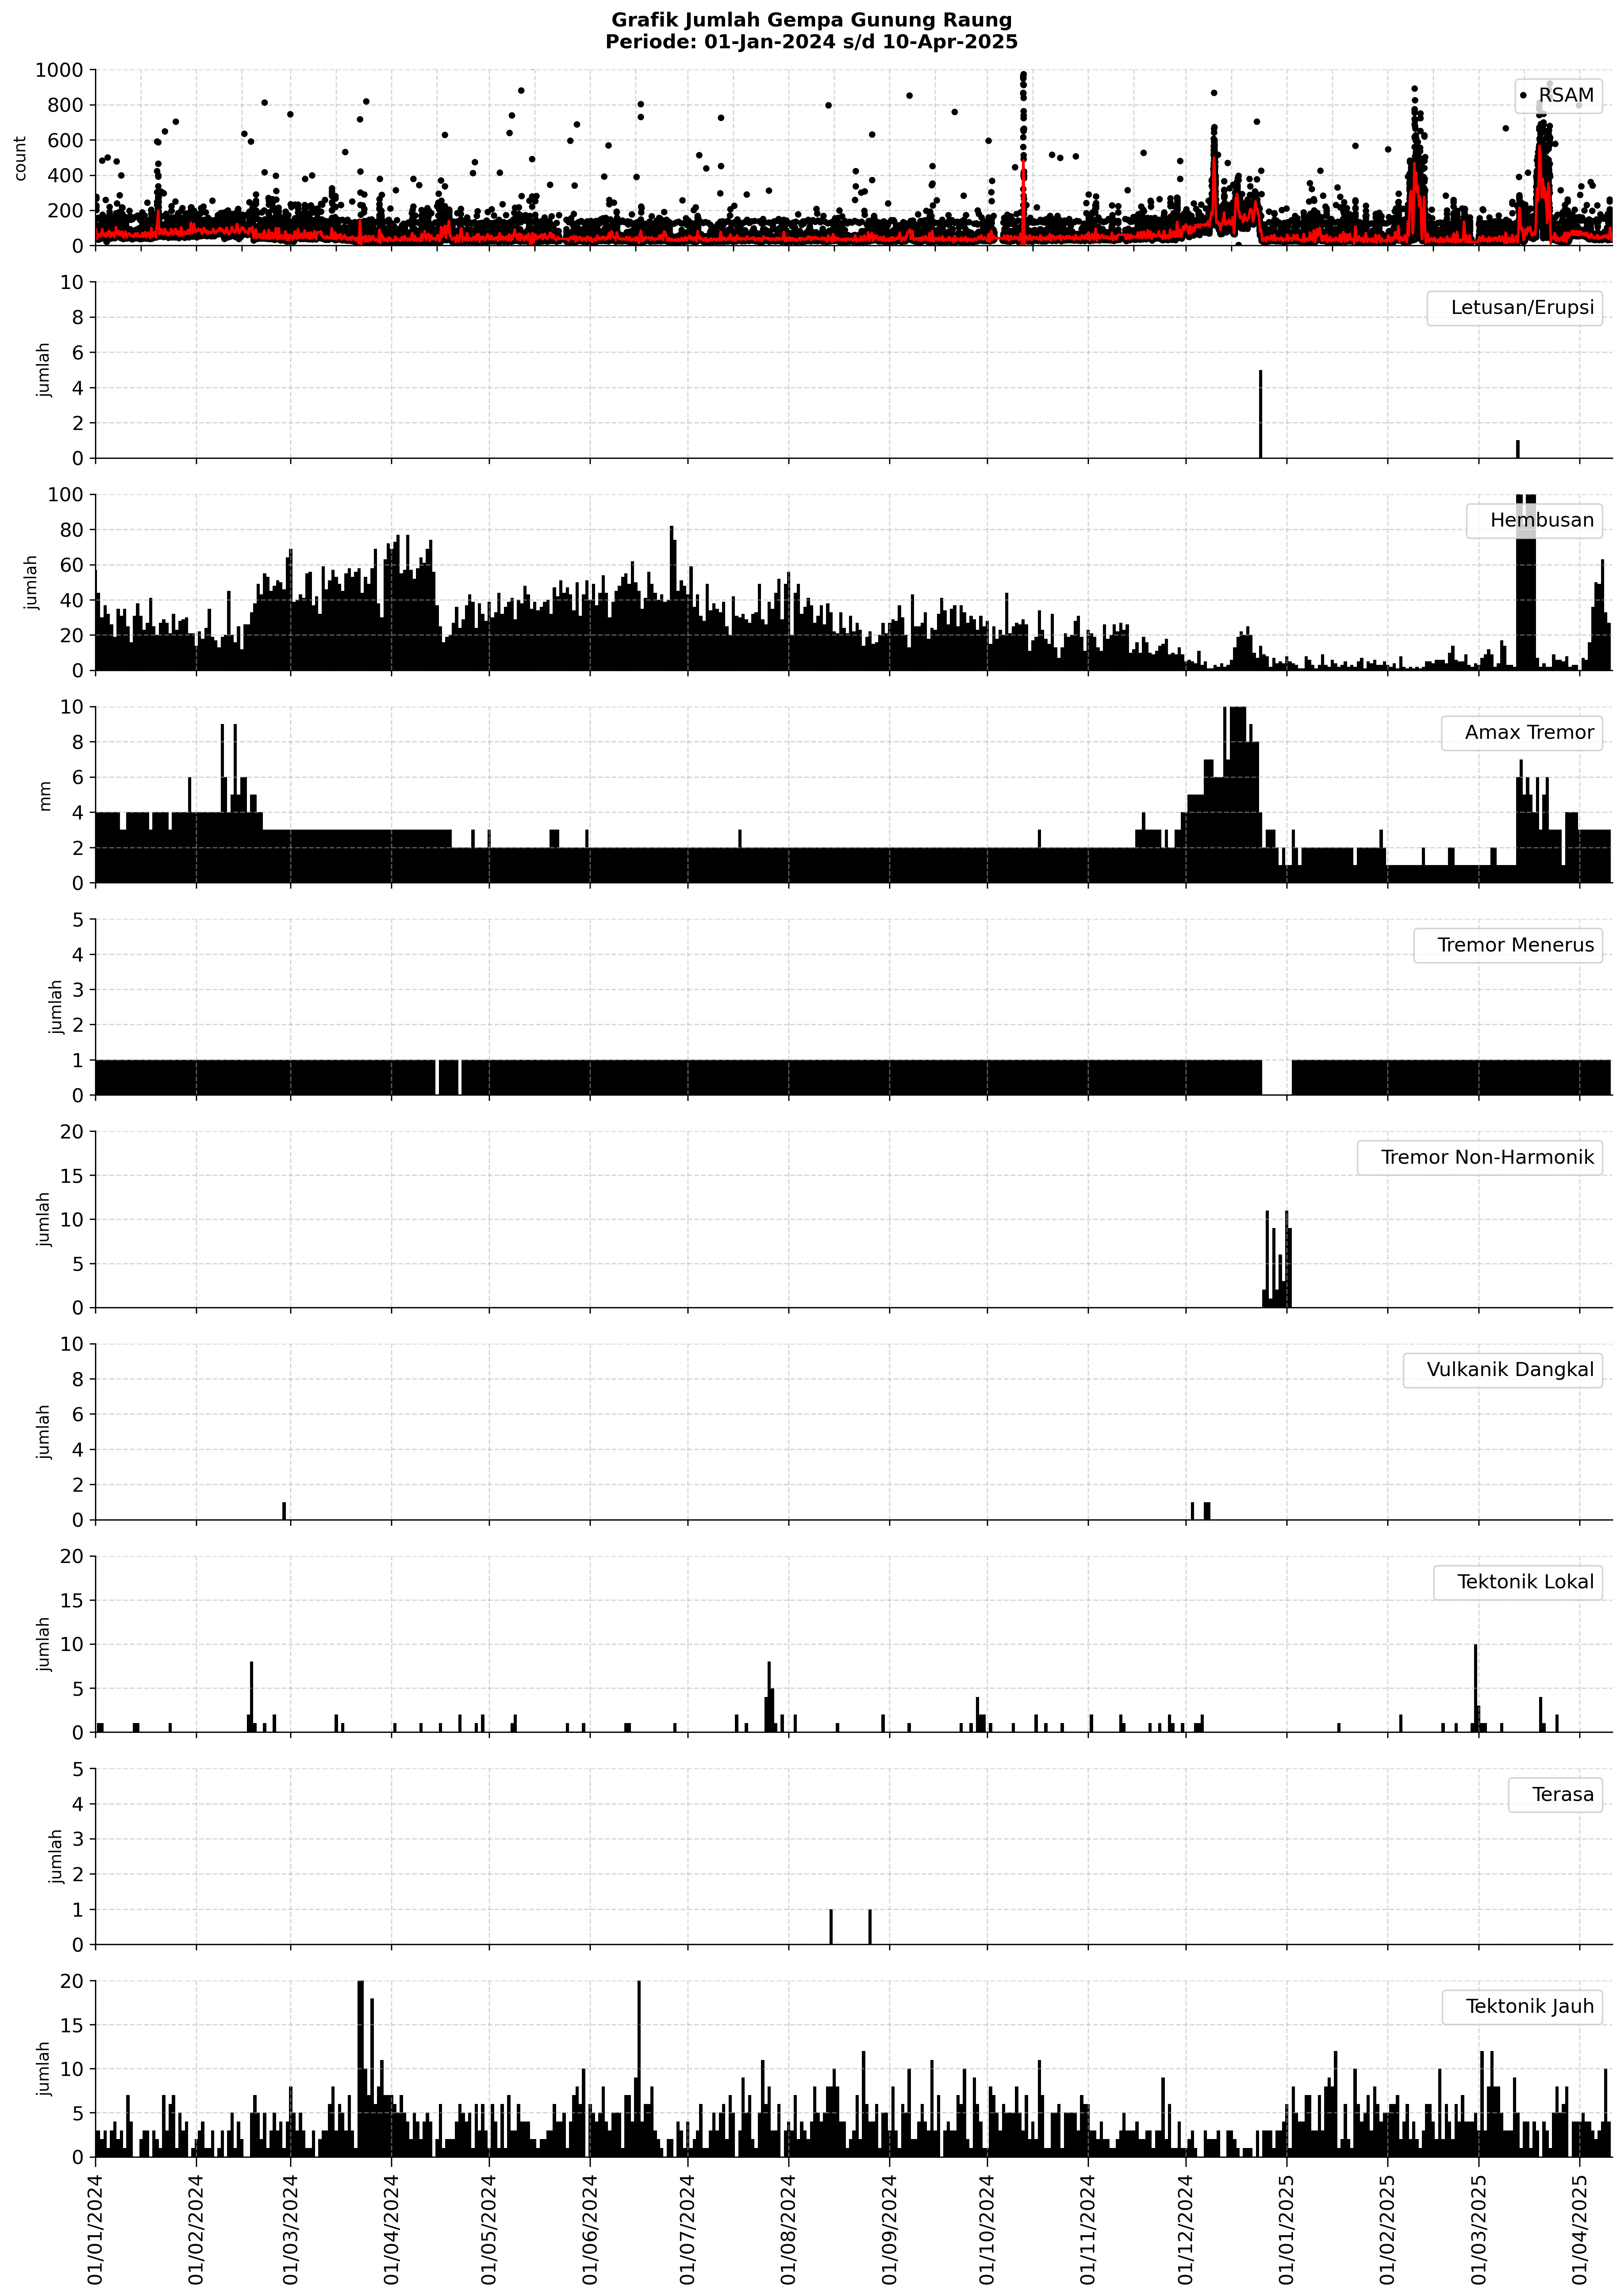

Data Jumlah Gempa Terakhir : 10-Apr-2025
Data RSAM Terakhir : 11-Apr-2025 07:00 WIB


In [5]:
# Import library
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from datetime import datetime, timedelta
from scipy.signal import savgol_filter

# Tuliskan nama gunung
gunung = 'Raung'

# Tentukan tanggal awal dan akhir dalam format dd-mm-yyyy 
tanggal_awal = '01-01-2024'
tanggal_akhir = '10-04-2025'

# Tentukan path file data gempa harian
path_file = 'D:/Shortchut Dekstop/kegempaan-harian-raung.csv'

# Tentukan path lokasi folder data RSAM
directory = r"//angsa/data/Rsam/10Minute"
stasiun = "MLLR"

nilai_maks_axis_rsam = 1000
interval_axis_rsam = 200

# Mengambil nilai bulan dan tahun
start_year = int(tanggal_awal[6:])
start_month = int(tanggal_awal[3:5])
end_year = int(tanggal_akhir[6:])
end_month = int(tanggal_akhir[3:5])

tanggal_awal = pd.to_datetime(tanggal_awal, format='%d-%m-%Y')
tanggal_akhir = pd.to_datetime(tanggal_akhir, format='%d-%m-%Y')

# Urutan grafik, nilai axis y, dan warna grafik untuk setiap jenis gempa
jenis_params = {
    'Letusan/Erupsi': {'limits': (0, 10), 'interval': 2, 'color': 'black'},
    'Hembusan': {'limits': (0, 100), 'interval': 20, 'color': 'black'},
    'Amax Tremor': {'limits': (0, 10), 'interval': 2, 'color': 'black'},
    'Tremor Menerus': {'limits': (0, 5), 'interval': 1, 'color': 'black'},
    'Tremor Non-Harmonik': {'limits': (0, 20), 'interval': 5, 'color': 'black'},
    'Vulkanik Dangkal': {'limits': (0, 10), 'interval': 2, 'color': 'black'},
    'Tektonik Lokal': {'limits': (0, 20), 'interval': 5, 'color': 'black'},
    'Terasa': {'limits': (0, 5), 'interval': 1, 'color': 'black'},
    'Tektonik Jauh': {'limits': (0, 20), 'interval': 5, 'color': 'black'}
}

# Membaca file jumlah gempa harian dari file CSV
data_gempa = pd.read_csv(path_file, parse_dates=['Category'], date_format='%d/%m/%y')
data_gempa['Category'] = pd.to_datetime(data_gempa['Category'], format='%d/%m/%y')
data_gempa_filtered = data_gempa[(data_gempa['Category'] >= tanggal_awal) & (data_gempa['Category'] <= tanggal_akhir)]

# Proses menggabungkan file-file 
# Nama file harus memiliki format standar earthworm, yaitu "yyyymm_network_station_componentRSAM10Min.DAT", contoh "202401_VG_MLLR_EHZRSAM10Min.DAT"
merged_data = pd.DataFrame()
files_to_merge = []  
for filename in os.listdir(directory):
    if filename.endswith(".DAT"):
        # Membaca nama file
        try:
            year = int(filename[:4])
            month = int(filename[4:6])
            channel_name = filename[10:14]
        except ValueError:
            # Skip file jika tidak dapat di-parse sebagai angka untuk tahun dan bulan
            continue
        # Memeriksa apakah file cocok dengan kriteria sesuai nama stasiun, waktu awal, dan waktu akhir yang ditentukan sebelumnya
        if (start_year < end_year):
            if ((year == start_year and month >= start_month) or (year == end_year and month <= end_month) or (year > start_year and year < end_year)) and channel_name == stasiun:
                files_to_merge.append(filename)  # Menambahkan nama file ke daftar
                # Membaca file dan menggabungkannya
                filepath = os.path.join(directory, filename)
                data = pd.read_csv(filepath, sep=',', header=None, names=['Time', 'RSAM'])
                merged_data = pd.concat([merged_data, data], ignore_index=True)
        else:
            if (year == start_year and month >= start_month and year == end_year and month <= end_month) and channel_name == stasiun:
                files_to_merge.append(filename)  # Menambahkan nama file ke daftar
                # Membaca file dan menggabungkannya
                filepath = os.path.join(directory, filename)
                data = pd.read_csv(filepath, sep=',', header=None, names=['Time', 'RSAM'])
                merged_data = pd.concat([merged_data, data], ignore_index=True)

merged_data['Time'] = pd.to_datetime(merged_data['Time'], format='%d-%b-%Y %H:%M:%S')
data_rsam_filtered = merged_data[(merged_data['Time'] >= tanggal_awal) & (merged_data['Time'] <= tanggal_akhir + pd.Timedelta(days=1))]

print('Data Jumlah gempa harian :')
print("________________________________")
print(data_gempa_filtered.head(5))
print("________________________________")
print('file RSAM :')
for item in files_to_merge:
    print(item)

# Membuat subplot untuk gempa dan rsam
fig, axes = plt.subplots(nrows=len(jenis_params) + 1, ncols=1, figsize=(14, 2*(len(jenis_params) + 1)), dpi=300)

# Plot data rsam di subplot pertama (axes[0])
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].plot(data_rsam_filtered['Time'], data_rsam_filtered['RSAM'], label='RSAM', marker='.', linestyle='', color='black')
axes[0].tick_params(axis='y', labelsize=12)

# Mengatur label x-axis di subplot pertama
axes[0].tick_params(axis='x')
axes[0].set_xlim(tanggal_awal, tanggal_akhir + pd.Timedelta(days=1))
date_format = mdates.DateFormatter('%d/%m/%Y')
axes[0].xaxis.set_major_formatter(date_format)
axes[0].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=[1, 15]))
axes[0].set_xticklabels([])
axes[0].set_ylim(0, nilai_maks_axis_rsam)
axes[0].yaxis.set_major_locator(MultipleLocator(interval_axis_rsam))
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_ylabel('count')
axes[0].legend(loc='upper right', frameon=True, fontsize=12, handlelength=0) 

# Savitzky-Golay smoothing (garis tren)
window_size = 100  # Panjang jendela smoothing
degree = 3        # Derajat polinomial
smoothed_data = savgol_filter(data_rsam_filtered['RSAM'], window_size, degree)
axes[0].plot(data_rsam_filtered['Time'], smoothed_data, linestyle='-', color='red')

# Plot grafik tiap jenis gempa
for i, (jenis, params) in enumerate(jenis_params.items()):    
    y_min, y_max = params['limits']
    interval = params['interval']
    warna = params['color']
    axes[i + 1].grid(True, linestyle='--', alpha=0.5)
    axes[i + 1].bar(data_gempa_filtered['Category'], data_gempa_filtered[jenis], label=jenis, color=warna, width=1.0)
    axes[i + 1].tick_params(axis='x', rotation=90)
    axes[i + 1].set_xlim(tanggal_awal, tanggal_akhir + pd.Timedelta(days=1))
    axes[i + 1].xaxis.set_major_formatter(date_format)
    axes[i + 1].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=[1]))
    axes[i + 1].set_ylim(y_min, y_max)
    axes[i + 1].yaxis.set_major_locator(MultipleLocator(interval))
    axes[i + 1].spines['top'].set_visible(False)
    axes[i + 1].spines['right'].set_visible(False)
    axes[i + 1].tick_params(axis='x', labelsize=12)
    axes[i + 1].tick_params(axis='y', labelsize=12)
    if jenis == 'Amax Tremor':
        axes[i + 1].set_ylabel('mm')
    else:
        axes[i + 1].set_ylabel('jumlah')
    axes[i + 1].legend(loc='upper right', frameon=True, fontsize=12, handlelength=0) 
    
    # Menampilkan axis tanggal pada baris paling bawah
    if i != len(jenis_params) - 1:
        axes[i + 1].set_xticklabels([])
    else:
        axes[i + 1].tick_params(axis='x', which='both', length=6)     

# Judul grafik
judul_grafik = f'Grafik Jumlah Gempa Gunung {gunung}'
periode = f'Periode: {tanggal_awal.strftime("%d-%b-%Y")} s/d {tanggal_akhir.strftime("%d-%b-%Y")}'
plt.suptitle(f"{judul_grafik}\n{periode}\n", fontsize=12, fontweight='bold', ha='center')

# Menampilkan grafik
plt.tight_layout()
plt.show()

last_row_harian = data_gempa_filtered.iloc[-1]
timestamp_terakhir_harian = last_row_harian['Category']
data_terakhir_harian = timestamp_terakhir_harian.strftime('%d-%b-%Y')
print("Data Jumlah Gempa Terakhir :", data_terakhir_harian)

last_row_rsam = data_rsam_filtered.iloc[-1]
timestamp_terakhir_rsam = last_row_rsam['Time']
utc7_rsam = timestamp_terakhir_rsam + pd.Timedelta(hours=7)
wib_time_rsam = utc7_rsam.strftime('%d-%b-%Y %H:%M')
print("Data RSAM Terakhir :", wib_time_rsam, "WIB")

# Mukijo - PVMBG - 2025
# WA 0856-4334-6785